<a href="https://colab.research.google.com/github/laistebas/analise_preditiva/blob/main/PIntV_analise_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desempenho Operacional Ferroviário: Abordagem Frequentista e Bayesiana em Perspectiva**

## Definição do dataset

In [ ]:
import pandas as pd
import os

# Função para processar um arquivo
def processar_arquivo(arquivo):
    df = pd.read_csv(arquivo, sep=";", encoding='latin-1')

    # Extrair o ano do nome do arquivo
    ano = int(os.path.basename(arquivo).split('_')[-1].split('.')[0])

    # Adicionar a coluna "Ano"
    df['Ano'] = ano

    # Extrair o mês a partir de "Mes_Ano"
    df['Mes'] = pd.to_datetime(df['Mes_Ano'], format='%m/%Y').dt.month

    # Converter a coluna "TU" para float
    df['TU'] = df['TU'].str.replace('.', '', regex=False).astype(float)

    mapeamento = {
      'RMN': 'Rumo',
      'RMS': 'Rumo',
      'RMP': 'Rumo',
      'RMO': 'Rumo',
      'RMC': 'Rumo',
      'FIEVV': 'Rumo',
      'EFC': 'Vale',
      'EFVM': 'Vale',
      'FCA': 'VLI',
      'FNSTN': 'VLI'
    }

    df['Empresas'] = df['Ferrovia'].replace(mapeamento)
    return df

# Diretório onde estão os arquivos históricos de 2018 a 2023
diretorio_historico = '/content/drive/MyDrive/CD/PI IV/Dados-Artigo' #'/content/Dados'

# Processar os arquivos históricos e armazenar em uma lista
dataframes_historico = [processar_arquivo(os.path.join(diretorio_historico, arquivo)) for arquivo in os.listdir(diretorio_historico) if arquivo.startswith('producao_origem_destino')]

# Concatenar os DataFrames históricos em um único DataFrame
df_historico = pd.concat(dataframes_historico)
df_historico


,Mes_Ano,Ferrovia,Mercadoria_ANTT,Estacao_Origem,UF_Origem,Estacao_Destino,UF_Destino,TU,TKU,Ano,Mes,Empresas
0,01/2013,EFC,Ferro Gusa,Açailândia,MA,Ponta da Madeira Pêra do Píer,MA,109295.0,57.456.382,2013,1,Vale
1,01/2013,EFC,Ferro Gusa,Marabá,PA,Ponta da Madeira Pêra do Píer,MA,53155.0,39.903.458,2013,1,Vale
2,01/2013,EFC,Ferro Gusa,Rosário,MA,Ponta da Madeira Pêra do Píer,MA,10185.0,526.565,2013,1,Vale
3,01/2013,EFC,Ferro Gusa,Santa Inês,MA,Ponta da Madeira Pêra do Píer,MA,9443.0,2.131.285,2013,1,Vale
4,01/2013,EFC,Gasolina,Itaqui Base Combustível,MA,Açailândia,MA,10410.0,5.444.430,2013,1,Vale
...,...,...,...,...,...,...,...,...,...,...,...,...
7933,12/2023,RMS,Soja,Maringa,PR,D Pedro II,PR,32208.0,20.991.816,2023,12,Rumo
7934,12/2023,RMS,Soja,Rolandia,PR,D Pedro II,PR,16889.0,10.332.149,2023,12,Rumo
7935,12/2023,RMS,Soja,Tupancireta,RS,Rio Grande,RS,3161.0,2.158.725,2023,12,Rumo
7936,12/2023,RMS,Ureia,D Pedro II,PR,Maringa,PR,3089.0,2.013.280,2023,12,Rumo


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Calcular a soma total de TU para cada empresa em cada ano
df_mes_ano = df_historico.groupby(['Mes_Ano']).agg({'TU': 'sum'}).reset_index()
df_mes_ano

,Mes_Ano,TU
0,01/2013,33625427.0
1,01/2014,36120925.0
2,01/2015,38478832.0
3,01/2016,37661520.0
4,01/2017,40515900.0
...,...,...
127,12/2019,37898054.0
128,12/2020,42482082.0
129,12/2021,41476094.0
130,12/2022,41449737.0


## Processos Gaussianos TS2

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt


### Teste df de Mes_Ano e TU

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Criação do DataFrame
df = df_mes_ano

# Conversão da coluna 'Mes_Ano' para datetime
df['Mes_Ano'] = pd.to_datetime(df['Mes_Ano'], format='%m/%Y')

# Ordenar os dados por 'Mes_Ano' se necessário
df.sort_values(by='Mes_Ano', inplace=True)

# Normalização do índice de tempo
df['days'] = (df['Mes_Ano'] - df['Mes_Ano'].min()).dt.days
min_day = df['days'].min()
max_day = df['days'].max()
normalized_index = (df['days'] - min_day) / (max_day - min_day)
df['days'] = normalized_index

# Normalização dos valores de TU
max_TU = df['TU'].max()
min_TU = df['TU'].min()
df['TU_normalized'] = (df['TU'] - min_TU) / (max_TU - min_TU)

# Selecionar os dados de interesse
df_data = df[['days', 'TU_normalized']]

# Dividir os dados em treinamento e teste
prop_train = 0.8
n_train = round(prop_train * len(df_data))

x_train = df_data['days'][:n_train].values
y_train = df_data['TU_normalized'][:n_train].values

x_test = df_data['days'][n_train:].values
y_test = df_data['TU_normalized'][n_train:].values



In [ ]:
df_data

,days,TU_normalized
0,0.000000,0.121070
11,0.007777,0.000000
22,0.014802,0.187020
33,0.022579,0.171180
44,0.030105,0.279772
...,...,...
87,0.969393,0.756958
98,0.977170,0.823028
109,0.984696,0.757704
120,0.992474,0.671020


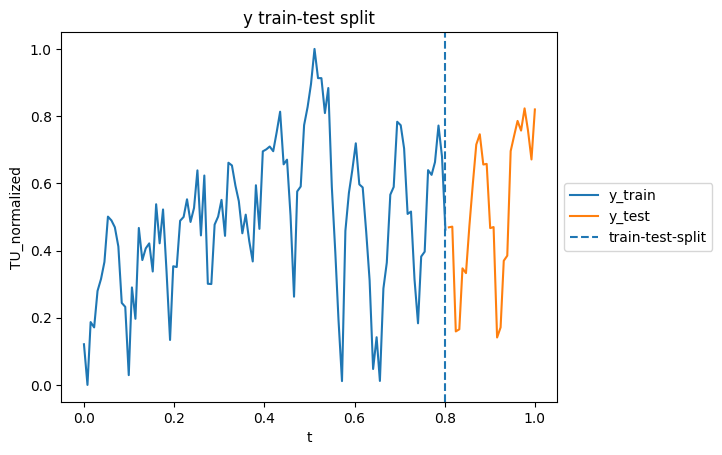

In [ ]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split', xlabel='t', ylabel='TU_normalized')
plt.show()

In [ ]:

with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0.5,0.05)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    #Antes sigma=1; Atribuiu-se sigma mínimo - incerteza adicionada aos dados observados (ruído) deve ter um desvio padrão mínimo de 0.1
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)

with model:
  prior = pm.sample_prior_predictive()


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


<ipython-input-27-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-27-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

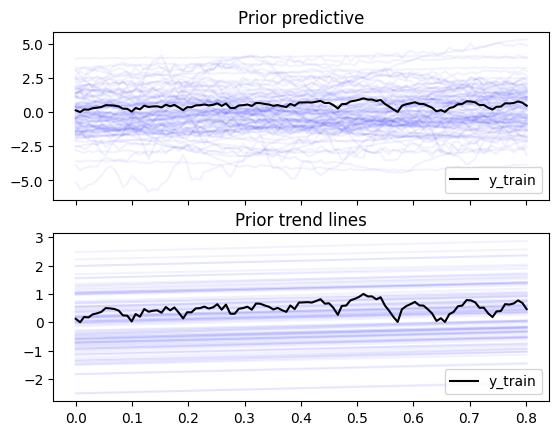

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")


In [ ]:
with model:
  trace_approx = pm.fit()
  trace = trace_approx.sample()

In [ ]:
pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.014,0.794,-1.507,1.504,0.036,0.028,501.0,414.0,NaN
b,0.495,0.127,0.277,0.735,0.005,0.004,652.0,428.0,NaN
l_ratquad,0.927,0.939,0.041,2.584,0.038,0.028,562.0,370.0,NaN
alpha_ratquad,1.027,0.858,0.136,2.717,0.046,0.033,379.0,345.0,NaN
sigma_ratquad,0.783,0.707,0.069,2.110,0.030,0.022,634.0,515.0,NaN
...,...,...,...,...,...,...,...,...,...
trend[101],0.396,0.798,-1.221,1.751,0.036,0.028,510.0,405.0,NaN
trend[102],0.400,0.798,-1.217,1.754,0.036,0.028,510.0,405.0,NaN
trend[103],0.403,0.798,-1.213,1.758,0.036,0.028,510.0,405.0,NaN
trend[104],0.407,0.798,-1.209,1.761,0.036,0.028,509.0,405.0,NaN


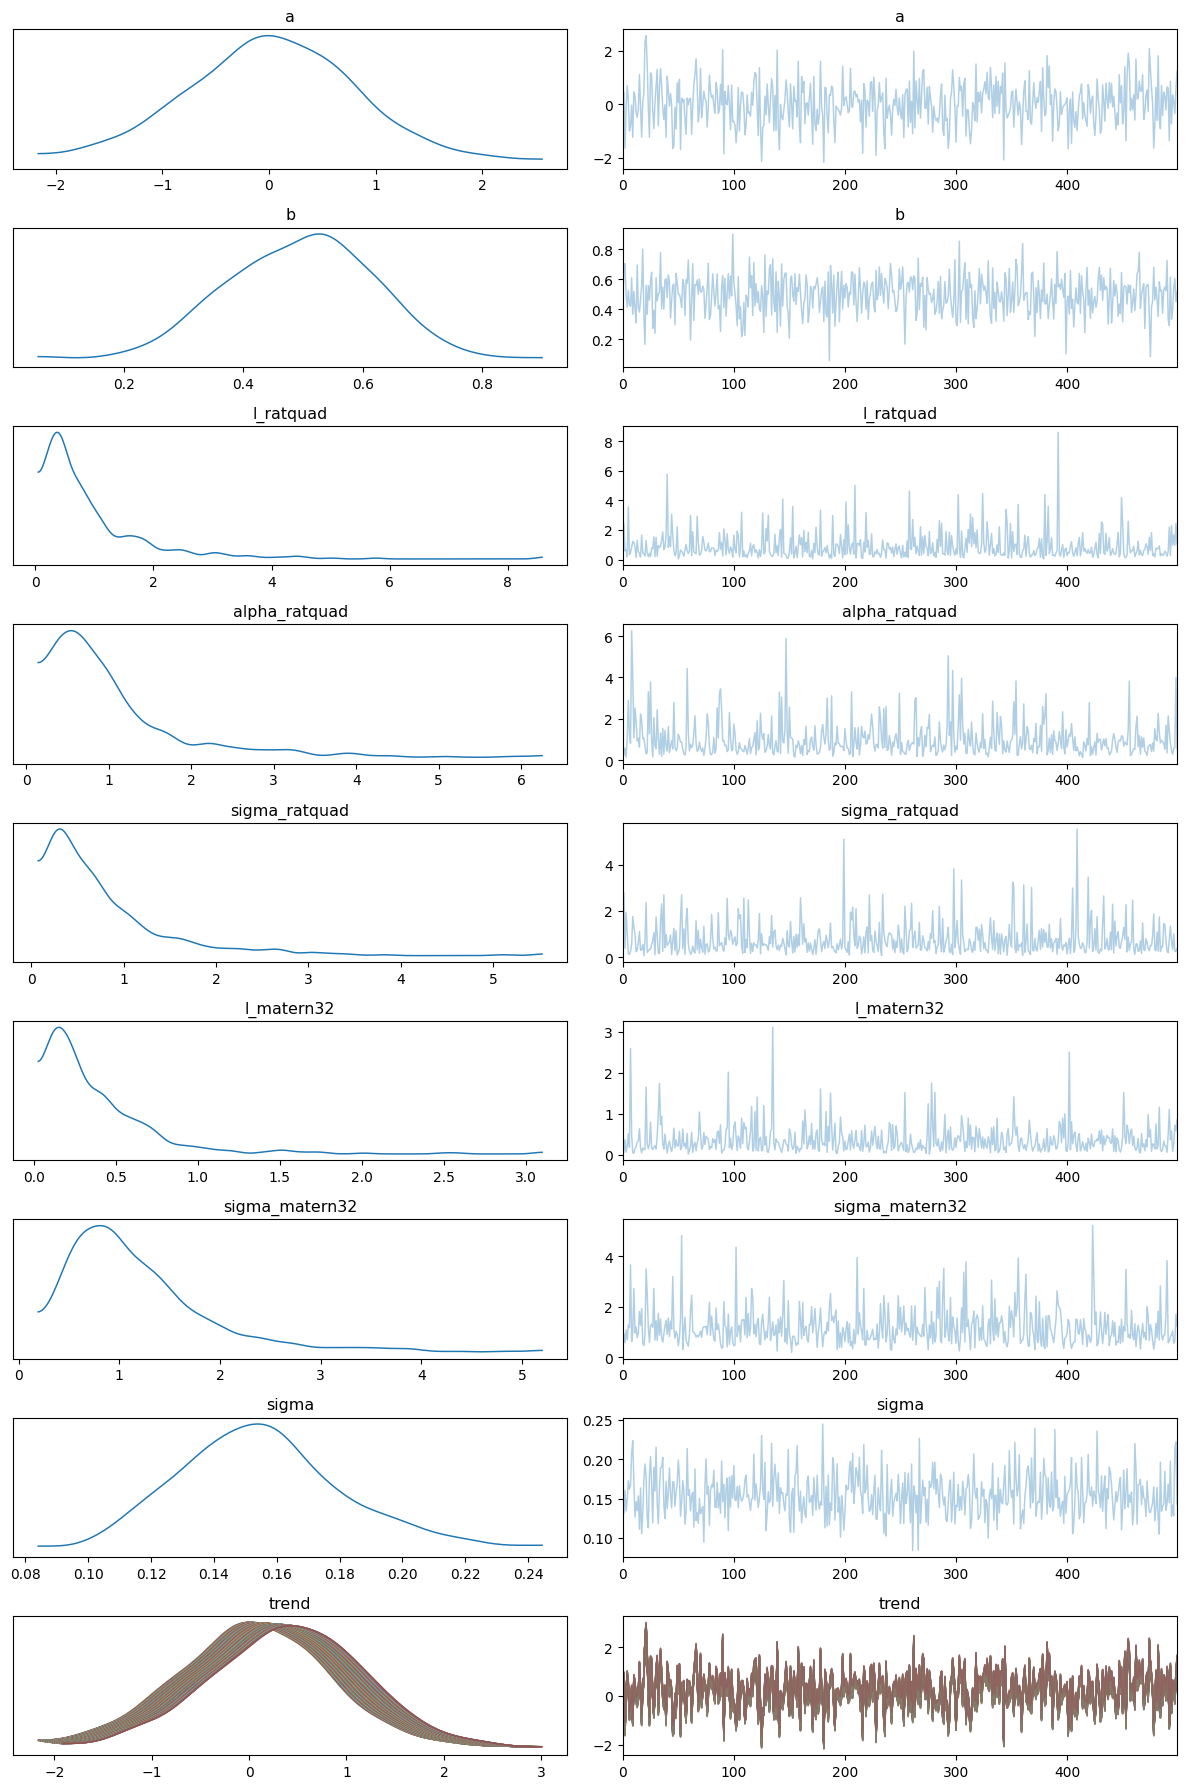

In [ ]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

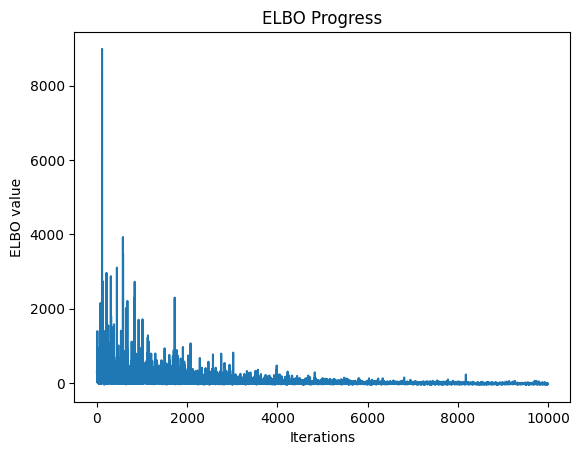

In [ ]:
# Plot do progresso do ELBO (Evidence Lower Bound)
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [ ]:
with model:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_test"])


In [ ]:
pred_m

Inference data with groups:
	> posterior_predictive
	> observed_data

In [ ]:
pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_test"])
pred_samples

<xarray.DataArray 'x_test' (x_test_dim_2: 26, sample: 500)>
array([[ 0.69466569,  0.6913096 ,  0.83152313, ...,  0.65561651,
         0.44713605,  0.44498858],
       [ 0.59756851,  0.70900235,  0.99781463, ...,  0.6637541 ,
         0.51866286,  0.38081545],
       [ 0.55728196,  0.7379889 ,  1.12053613, ...,  0.65069878,
         0.60778079,  0.31700554],
       ...,
       [ 1.42336702,  1.20691442, -0.4547161 , ...,  0.7420011 ,
         1.83677059, -0.1831313 ],
       [ 1.19112292,  1.21482445, -0.39735738, ...,  0.7503978 ,
         1.82047771, -0.25435619],
       [ 0.90106251,  1.22203542, -0.30857207, ...,  0.76921329,
         1.80475785, -0.31587048]])
Coordinates:
  * x_test_dim_2  (x_test_dim_2) int64 0 1 2 3 4 5 6 7 ... 19 20 21 22 23 24 25
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [ ]:
# y_pred_samples = pred_samples["x_test"].values

# Revertendo a normalização das predições
y_pred_original_scale = pred_samples * (max_TU - min_TU) + min_TU
y_pred_original_scale

<xarray.DataArray 'x_test' (x_test_dim_2: 26, sample: 500)>
array([[46491389.91536421, 46416111.6132668 , 49561150.57689083, ...,
        45615503.11414494, 40939213.0892317 , 40891044.42993972],
       [44313465.93166008, 46812966.38398391, 53291127.38430302, ...,
        45798032.06760346, 42543584.50173905, 39451618.48298763],
       [43409824.60512055, 47463144.75013441, 56043813.73639253, ...,
        45505196.6783838 , 44542531.02818953, 38020339.95437312],
       ...,
       [62836417.36580816, 57981309.25391623, 20710351.76368719, ...,
        47553139.8798177 , 72109204.83949906, 26802094.4686049 ],
       [57627100.44136347, 58158734.05939793, 21996928.0109501 , ...,
        47741480.8821243 , 71743749.75259343, 25204495.0661099 ],
       [51120943.3255262 , 58320478.72962764, 23988413.74862417, ...,
        48163518.89050629, 71391147.90989605, 23824708.0354583 ]])
Coordinates:
  * x_test_dim_2  (x_test_dim_2) int64 0 1 2 3 4 5 6 7 ... 19 20 21 22 23 24 25
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

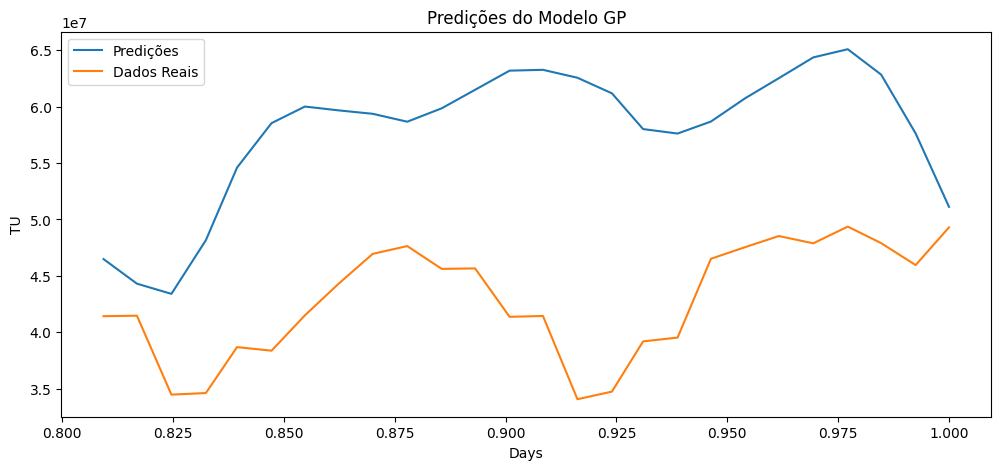

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reverter a normalização das predições
y_pred_normalized = pred_m.posterior_predictive["x_test"].values[0][0]
y_pred_original_scale = y_pred_normalized * (max_TU - min_TU) + min_TU

# Reverter a normalização dos dados reais
y_test_original_scale = y_test * (max_TU - min_TU) + min_TU

# Plotando as predições e os dados reais
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# Plot das predições (já escalonadas de volta à forma original)
sns.lineplot(ax=ax, x=x_test.flatten(), y=y_pred_original_scale, label='Predições')

# Plot dos dados reais (já escalonados de volta à forma original)
sns.lineplot(x=x_test.flatten(), y=y_test_original_scale, label='Dados Reais', ax=ax)

ax.set_title("Predições do Modelo GP")
ax.set_xlabel("Days")
ax.set_ylabel("TU")
plt.legend()
plt.show()

<Axes: >

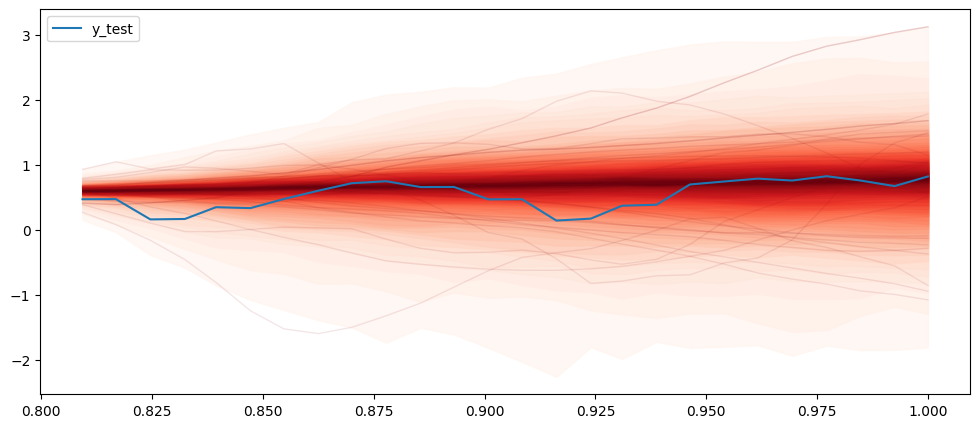

In [ ]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples.T, x_test);
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

In [ ]:
y_pred = pred_m.posterior_predictive["x_test"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_test).sum()/len(y_test)}")

MAE: 0.1690958007929488


In [ ]:
pred_m.posterior_predictive["x_test"].values[0][0]

array([ 4.51025068e-01,  3.93254793e-01,  3.25682513e-01,  2.82184752e-01,
        2.13080131e-01,  1.18680901e-01,  6.39489006e-02,  2.27658506e-02,
       -3.65186290e-04,  4.81313602e-03,  2.72645611e-02,  1.44094757e-02,
        1.10637655e-02,  3.58802903e-02,  7.50999957e-02,  1.36166726e-01,
        1.89766052e-01,  2.52409776e-01,  3.15986073e-01,  3.24570267e-01,
        3.11960502e-01,  2.95264211e-01,  3.29176933e-01,  3.80922202e-01,
        4.47505676e-01,  4.94440476e-01])

<Axes: >

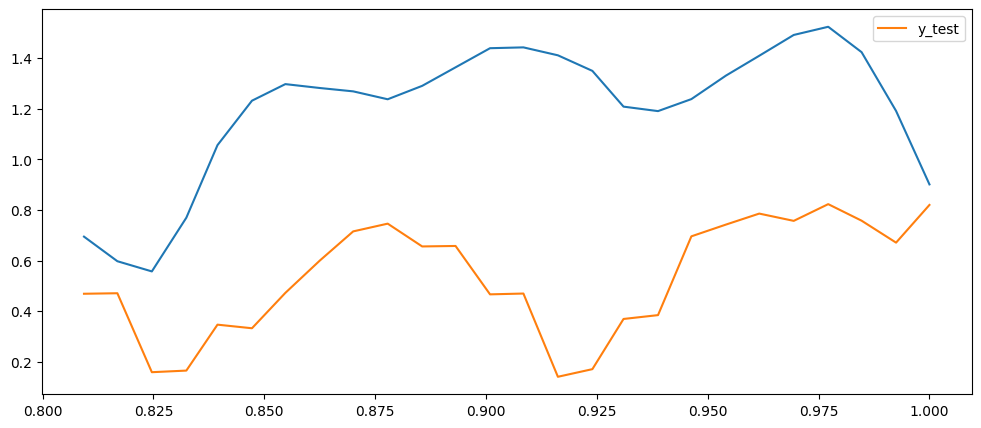

In [ ]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

sns.lineplot(ax=ax, x=x_test.flatten(),y=pred_m.posterior_predictive["x_test"].values[0][0])

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

### Teste Model_2

Adição de ExpQuad Covariance (covariância adicional para capturar diferentes padrões nos dados);

Termo Quadrático na Tendência (c * x_train**2) no modelo de tendência para capturar possíveis não-linearidades;

Prior de sigma para sigma=0.5 para permitir maior flexibilidade no modelo.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Criação do DataFrame
df = df_mes_ano

# Conversão da coluna 'Mes_Ano' para datetime
df['Mes_Ano'] = pd.to_datetime(df['Mes_Ano'], format='%m/%Y')

# Ordenar os dados por 'Mes_Ano' se necessário
df.sort_values(by='Mes_Ano', inplace=True)

# Normalização do índice de tempo
df['days'] = (df['Mes_Ano'] - df['Mes_Ano'].min()).dt.days
min_day = df['days'].min()
max_day = df['days'].max()
normalized_index = (df['days'] - min_day) / (max_day - min_day)
df['days'] = normalized_index

# Normalização dos valores de TU
max_TU = df['TU'].max()
min_TU = df['TU'].min()
df['TU_normalized'] = (df['TU'] - min_TU) / (max_TU - min_TU)

# Selecionar os dados de interesse
df_data = df[['days', 'TU_normalized']]

# Dividir os dados em treinamento e teste
prop_train = 0.8
n_train = round(prop_train * len(df_data))

x_train = df_data['days'][:n_train].values
y_train = df_data['TU_normalized'][:n_train].values

x_test = df_data['days'][n_train:].values
y_test = df_data['TU_normalized'][n_train:].values
df_data


In [ ]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


with pm.Model() as model_2:

    # Funções de Covariância
    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1)

    # Tentativa com função de covariância adicional
    l_expquad = pm.HalfNormal('l_expquad', sigma=1)
    sigma_expquad = pm.HalfNormal('sigma_expquad', sigma=1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)
    cov_expquad = sigma_expquad * pm.gp.cov.ExpQuad(1, l_expquad)

    # Combinação das Covariâncias
    cov = cov_ratquad + cov_matern32 + cov_expquad

    # Modelo de Tendência
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0.5, 0.05)
    c = pm.Normal("c", 0, 0.01)  # Termo quadrático adicional
    trend = pm.Deterministic("trend", a + b * x_train + c * x_train**2)
    M = pm.gp.mean.Linear([b], a)

    # Processo Gaussiano
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=0.5)  # Ajuste do Prior
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1, 1), y=y_train, noise=sigma)



/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with model_2:
    prior_2 = pm.sample_prior_predictive()

<ipython-input-88-bc30c08f3c76>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_2, group="prior_predictive", num_samples=100)["y"]
<ipython-input-88-bc30c08f3c76>:14: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_2, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

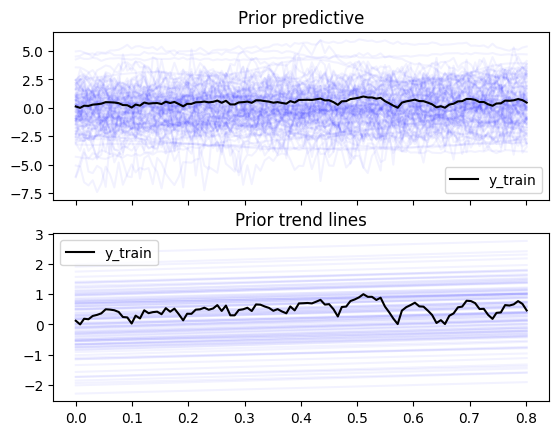

In [ ]:
# Plot dos Priors
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior_2, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior_2, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")


In [ ]:
with model_2:
    trace_approx = pm.fit()
    trace_2 = trace_approx.sample()

In [ ]:
pm.summary(trace_2)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.047,0.873,-1.380,1.883,0.041,0.029,432.0,409.0,NaN
b,0.497,0.124,0.264,0.740,0.007,0.005,368.0,380.0,NaN
c,-0.002,0.116,-0.234,0.198,0.005,0.004,474.0,454.0,NaN
l_ratquad,0.890,0.869,0.052,2.633,0.037,0.027,599.0,564.0,NaN
alpha_ratquad,0.996,0.741,0.111,2.181,0.038,0.027,371.0,383.0,NaN
...,...,...,...,...,...,...,...,...,...
trend[101],0.429,0.885,-1.174,2.048,0.041,0.029,461.0,428.0,NaN
trend[102],0.433,0.885,-1.165,2.059,0.041,0.029,461.0,428.0,NaN
trend[103],0.437,0.885,-1.161,2.062,0.041,0.029,462.0,428.0,NaN
trend[104],0.441,0.886,-1.158,2.065,0.041,0.029,462.0,428.0,NaN


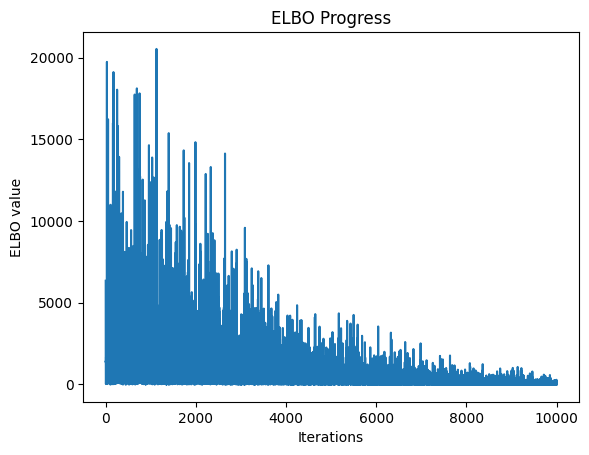

In [ ]:
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [ ]:
with model_2:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1, 1))
    pred_m_2 = pm.sample_posterior_predictive(trace_2, var_names=["x_test"])


In [ ]:
pred_samples_2 = az.extract(pred_m_2, group="posterior_predictive", var_names=["x_test"])
pred_samples_2

<xarray.DataArray 'x_test' (x_test_dim_2: 26, sample: 500)>
array([[ 0.58630938,  0.50700281,  0.55854673, ...,  0.62149996,
         0.5699493 ,  0.61493342],
       [ 0.56527917,  0.49621142,  0.54528566, ...,  0.64467152,
         0.6379433 ,  0.62284191],
       [ 0.5407594 ,  0.47959201,  0.54736476, ...,  0.6727074 ,
         0.75345709,  0.62260473],
       ...,
       [-0.69838638,  0.8971653 ,  0.38614873, ...,  0.93022031,
        -0.37768349,  0.81868935],
       [-0.7427092 ,  0.93026492,  0.32314303, ...,  0.91449305,
        -0.44356012,  0.84492796],
       [-0.7753346 ,  0.94087569,  0.28647003, ...,  0.8947546 ,
        -0.49123592,  0.86880185]])
Coordinates:
  * x_test_dim_2  (x_test_dim_2) int64 0 1 2 3 4 5 6 7 ... 19 20 21 22 23 24 25
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

<Axes: >

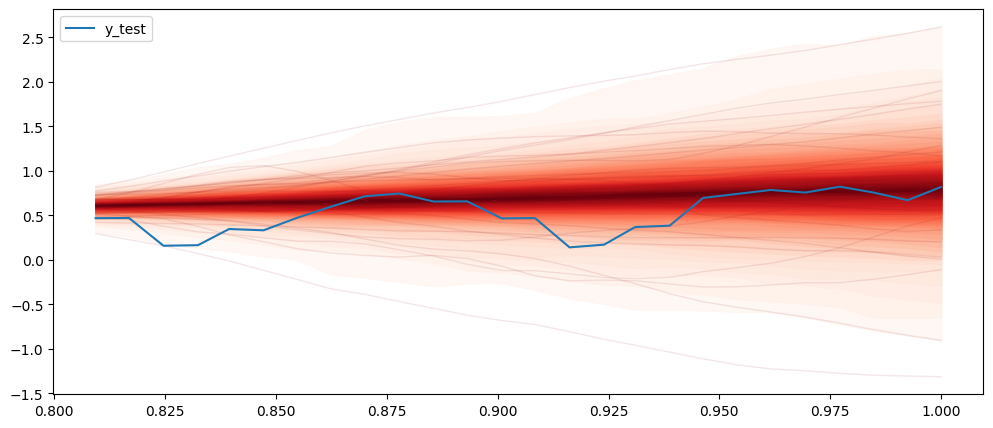

In [ ]:
# Plot das Predições
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples_2.T, x_test)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)


In [ ]:
# Calcular e Imprimir o MAE
y_pred = pred_m_2.posterior_predictive["x_test"].values.mean(axis=1)[0]
mae = np.mean(np.abs(y_pred - y_test))
print(f"MAE: {mae}")

MAE: 0.18798419117226547


## Prophet Model

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# import pandas as pd
# import os

# # Função para processar um arquivo
# def processar_arquivo(arquivo):
#     df = pd.read_csv(arquivo, sep=";", encoding='latin-1')

#     # Extrair o ano do nome do arquivo
#     ano = int(os.path.basename(arquivo).split('_')[-1].split('.')[0])

#     # Adicionar a coluna "Ano"
#     df['Ano'] = ano

#     # Extrair o mês a partir de "Mes_Ano"
#     df['Mes'] = pd.to_datetime(df['Mes_Ano'], format='%m/%Y').dt.month

#     # Converter a coluna "TU" para float
#     df['TU'] = df['TU'].str.replace('.', '', regex=False).astype(float)

#     mapeamento = {
#       'RMN': 'Rumo',
#       'RMS': 'Rumo',
#       'RMP': 'Rumo',
#       'RMO': 'Rumo',
#       'RMC': 'Rumo',
#       'FIEVV': 'Rumo',
#       'EFC': 'Vale',
#       'EFVM': 'Vale',
#       'FCA': 'VLI',
#       'FNSTN': 'VLI'
#     }

#     df['Empresas'] = df['Ferrovia'].replace(mapeamento)
#     return df

# # Diretório onde estão os arquivos históricos de 2018 a 2023
# diretorio_historico = '/content/drive/MyDrive/CD/PI IV/Dados-Artigo' #'/content/Dados'

# # Processar os arquivos históricos e armazenar em uma lista
# dataframes_historico = [processar_arquivo(os.path.join(diretorio_historico, arquivo)) for arquivo in os.listdir(diretorio_historico) if arquivo.startswith('producao_origem_destino')]

# # Concatenar os DataFrames históricos em um único DataFrame
# df_historico = pd.concat(dataframes_historico)
# df_historico

# Utilizando df_historico
# # Selecionar apenas colunas numéricas para escalonamento
# numeric_columns = df_historico.select_dtypes(include=[float, int]).columns
# X = df_historico[numeric_columns]

# # Escalonar os dados
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Criar um DataFrame com os dados escalonados
# X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# X_scaled_df

,TU,Ano,Mes
0,0.092046,-1.596770,-1.611214
1,-0.028360,-1.596770,-1.611214
2,-0.120520,-1.596770,-1.611214
3,-0.122111,-1.596770,-1.611214
4,-0.120037,-1.596770,-1.611214
...,...,...,...
83594,-0.073286,1.539204,1.583832
83595,-0.106141,1.539204,1.583832
83596,-0.135584,1.539204,1.583832
83597,-0.135739,1.539204,1.583832


In [ ]:
# Calcular a soma total de TU para cada empresa em cada ano
df_mes_ano = df_historico.groupby(['Mes_Ano']).agg({'TU': 'sum'}).reset_index()
df_mes_ano

,Mes_Ano,TU
0,01/2013,33625427.0
1,01/2014,36120925.0
2,01/2015,38478832.0
3,01/2016,37661520.0
4,01/2017,40515900.0
...,...,...
127,12/2019,37898054.0
128,12/2020,42482082.0
129,12/2021,41476094.0
130,12/2022,41449737.0


#### https://towardsdatascience.com/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525

In [ ]:
import pandas as pd

df_data = df_mes_ano
df_data['Mes_Ano'] = pd.to_datetime(df_data['Mes_Ano'], format='%m/%Y')

df_data_train = df_data[df_data["Mes_Ano"] < "01/2023"]
df_data_test = df_data[df_data["Mes_Ano"] >= "01/2023"]

display(df_data_train)

,Mes_Ano,TU
0,2013-01-01,33625427.0
1,2014-01-01,36120925.0
2,2015-01-01,38478832.0
3,2016-01-01,37661520.0
4,2017-01-01,40515900.0
...,...,...
126,2018-12-01,50730344.0
127,2019-12-01,37898054.0
128,2020-12-01,42482082.0
129,2021-12-01,41476094.0


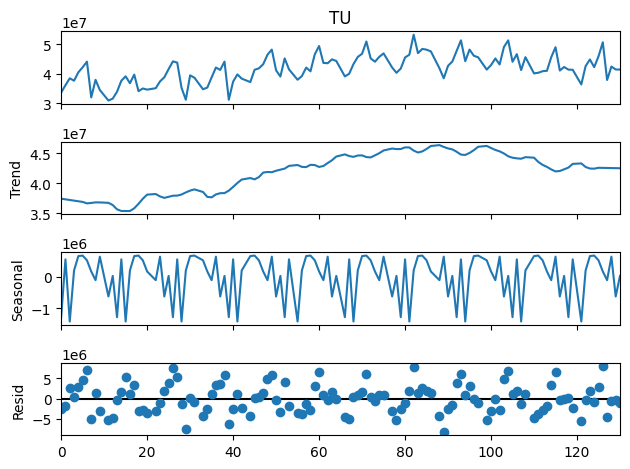

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_data_train.TU, model='additive', extrapolate_trend='freq', period=12)

decompose.plot().show()

In [ ]:
df_train_prophet = df_data_train

# date variable needs to be named "ds" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Mes_Ano": "ds"})

# target variable needs to be named "y" for prophet
df_train_prophet = df_train_prophet.rename(columns={"TU": "y"})

In [ ]:
model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw554zf8/ypbmanjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw554zf8/6nmet4h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29535', 'data', 'file=/tmp/tmpxw554zf8/ypbmanjc.json', 'init=/tmp/tmpxw554zf8/6nmet4h0.json', 'output', 'file=/tmp/tmpxw554zf8/prophet_modelugz8_zex/prophet_model-20240613044240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_future = model_prophet.make_future_dataframe(periods=12, freq='MS')
display(df_future)

,ds
0,2013-01-01
1,2013-02-01
2,2013-03-01
3,2013-04-01
4,2013-05-01
...,...
127,2023-08-01
128,2023-09-01
129,2023-10-01
130,2023-11-01


In [ ]:
# Gerar datas futuras para prever
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS').to_frame(index=False, name='ds')

# Fazer a previsão para essas datas futuras
forecast_prophet = model_prophet.predict(future_dates)

# Filtrar as previsões apenas para o ano de 2023
forecast_2023 = forecast_prophet[(forecast_prophet['ds'] >= '2023-01-01') & (forecast_prophet['ds'] <= '2023-12-31')]

# Obter o total previsto para o ano de 2023 somando as previsões mensais
total_2023 = forecast_2023['yhat'].sum()

print("Total previsto para o ano de 2023: {:.2f}".format(total_2023))

Total previsto para o ano de 2023: 486227218.81


In [ ]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,34016642.0,30704438.0,37273953.0
1,2013-02-01,30802577.0,27477019.0,34218900.0
2,2013-03-01,34080844.0,30663748.0,37275979.0
3,2013-04-01,34568427.0,31523436.0,37922024.0
4,2013-05-01,38259758.0,35063398.0,41601602.0
...,...,...,...,...
127,2023-08-01,44083466.0,40864754.0,47330292.0
128,2023-09-01,42661356.0,39287019.0,46051298.0
129,2023-10-01,44108060.0,40889172.0,47228798.0
130,2023-11-01,40834345.0,37639853.0,44207988.0


<ipython-input-76-10b28c26e138>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_test['Mes_Ano'] = pd.to_datetime(df_data_test['Mes_Ano'])


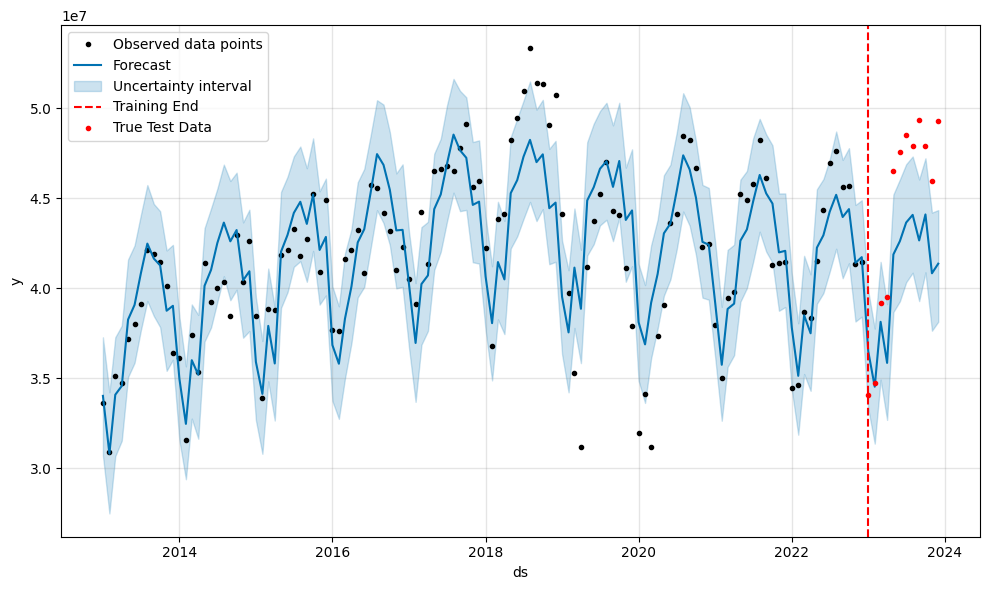

In [ ]:
import matplotlib.pyplot as plt

# plot the time series
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-12]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
df_data_test['Mes_Ano'] = pd.to_datetime(df_data_test['Mes_Ano'])
plt.plot(df_data_test['Mes_Ano'], df_data_test['TU'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()